In [1]:
import cv2
import dlib
import json
import os
from imutils import face_utils
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import supervisely as sly
from supervisely.geometry.graph import Node, KeypointsTemplate

In [2]:
load_dotenv("./.env")

True

## Задание 1

Скрипт */scripts/get-images.py* загружает 20 изображений из Гугл-поиска в */data/face-images/*, сохраняя их исходные имена.

Для обнаружения лиц/ключевых точек используется связка библиотек __[OpenCV](https://pypi.org/project/opencv-python/)__ и __[dlib](https://pypi.org/project/dlib/)__.

In [3]:
# Define Google Images search parameters
img_query = "donald trump face"
num_images = 20
img_path = "./data/face-images/"
get_images_command = f'./scripts/get-images.py "{img_query}" {num_images} "{img_path}" "{os.getenv("GOOGLE_API_KEY")}" "{os.getenv("CSE_ID")}"'
%run $get_images_command

Saved image 1 to ./data/face-images/
Saved image 2 to ./data/face-images/
Saved image 3 to ./data/face-images/
Saved image 4 to ./data/face-images/
Saved image 5 to ./data/face-images/
Saved image 6 to ./data/face-images/
Saved image 7 to ./data/face-images/
Saved image 8 to ./data/face-images/
Saved image 9 to ./data/face-images/
Saved image 10 to ./data/face-images/
Saved image 11 to ./data/face-images/
Saved image 12 to ./data/face-images/
Saved image 13 to ./data/face-images/
Saved image 14 to ./data/face-images/
Saved image 15 to ./data/face-images/
Saved image 16 to ./data/face-images/
Saved image 17 to ./data/face-images/
Saved image 18 to ./data/face-images/
Saved image 19 to ./data/face-images/
Saved image 20 to ./data/face-images/


In [4]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("./shape_predictor_68_face_landmarks.dat")

# Get all images' filenames from img_path
image_files = [f for f in os.listdir(img_path) if f.endswith(".png")]

In [5]:
def visualize_bboxes_and_landmarks(image_path, det, pred):
    image = cv2.imread(image_path)

    # Detect faces
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)

    # Loop over the faces
    for i, rect in enumerate(rects):
        # Draw bbox
        (x, y, w, h) = face_utils.rect_to_bb(rect)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Predict landmarks
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

        # Plot landmarks
        for x, y in shape:
            cv2.circle(image, (x, y), 1, (0, 0, 255), -1)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

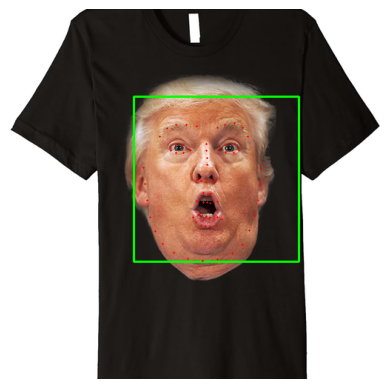

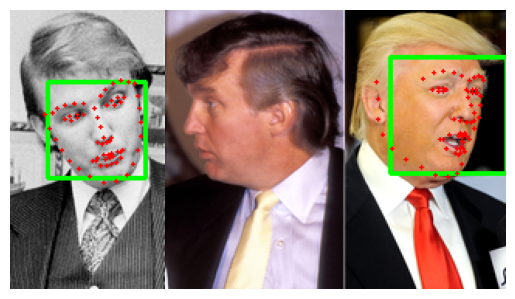

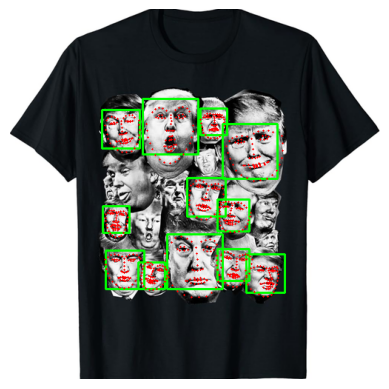

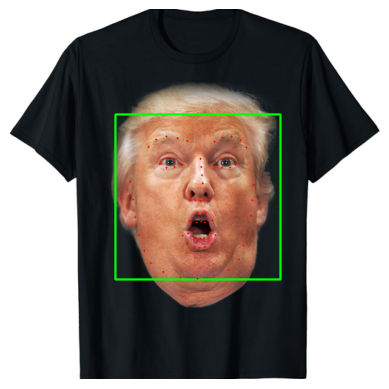

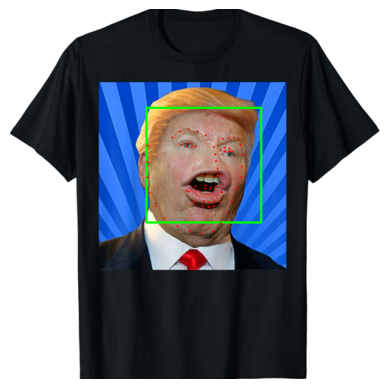

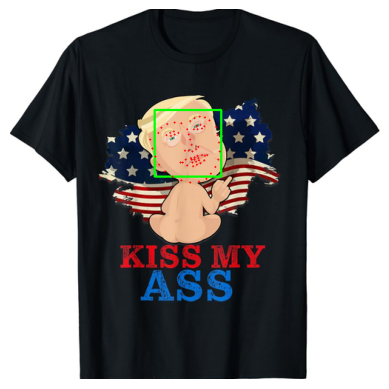

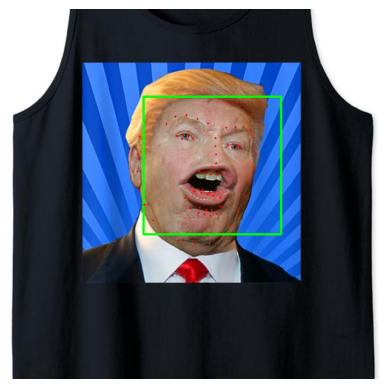

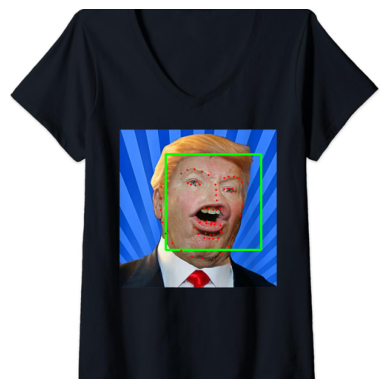

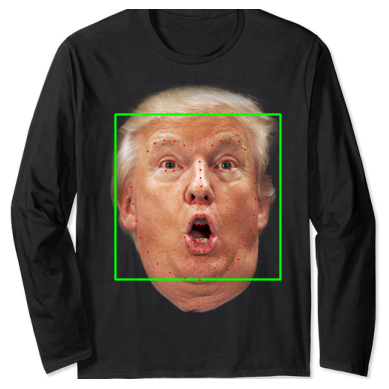

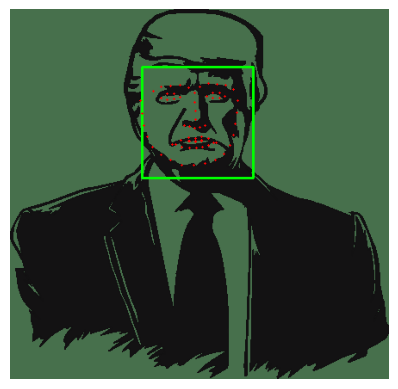

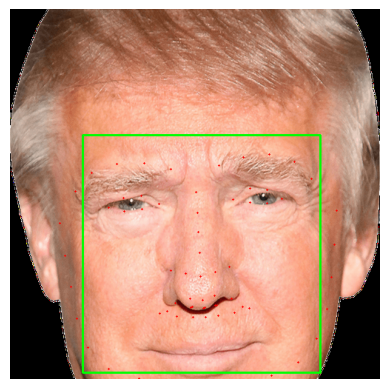

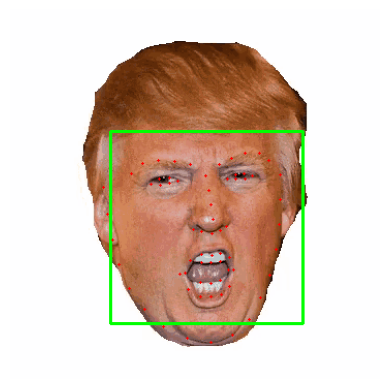

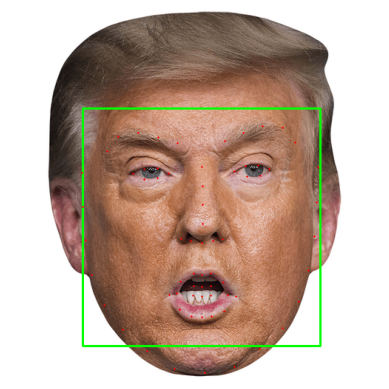

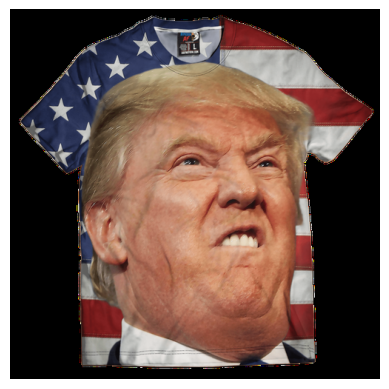

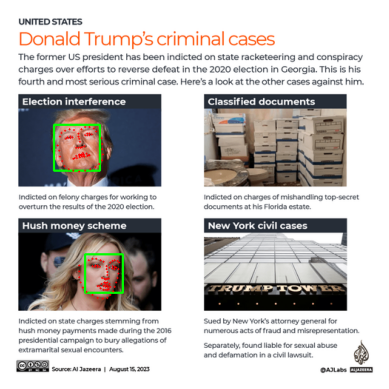

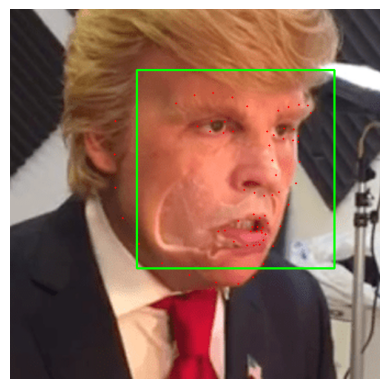

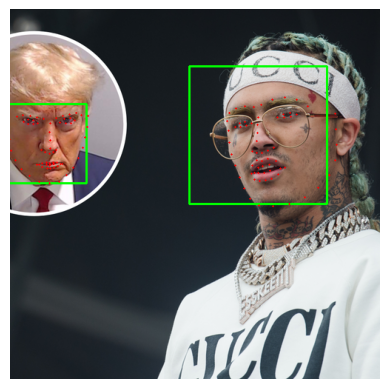

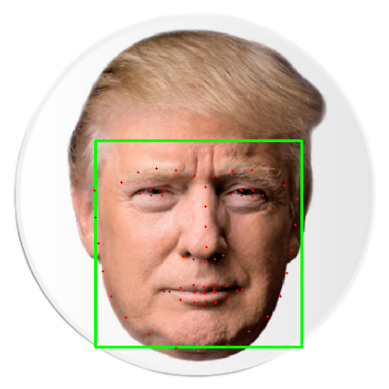

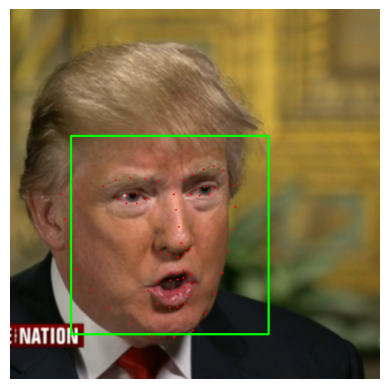

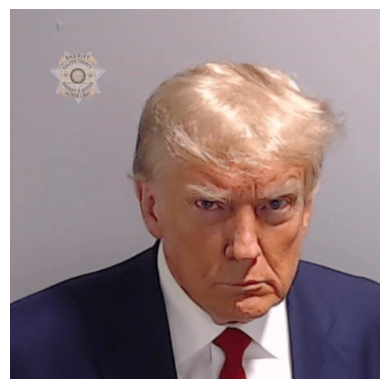

In [6]:
for image_file in image_files:
    image_link = os.path.join(img_path, image_file)
    visualize_bboxes_and_landmarks(image_link, det=detector, pred=predictor)

## Задание 2

В этом задании используется та же библиотека dlib для детекции точек на наборе данных __[Facial Keypoints Detection](https://www.kaggle.com/c/facial-keypoints-detection/data)__ с целью оценки точности детекции ключевых точек. Выясняется, что для части точек (брови) ошибка систематически выше, вероятнее всего, из-за разницы в подходах к разметке данных. Сложнее детектятся точки на лицах с бликами на линзах очков.

Возьмём обучающий набор training. Поскольку задача в том, чтобы оценить точность детектирования точек на размеченном наборе данных, для простоты оставим только те изображения, для которых размечены все 15 точек (альтернативно, можно было бы оставить частично размеченные изображения, проверяя детекцию на подмножестве точек, имеющих ground-truth пару).

Я получаю 68 predict-точек для каждого изображения. Поскольку в kaggle разметка для 15 точек, я отбираю 12 точек, которые оказываются эквивалентными разметке. Для отсутствующих 3-х других точек я получаю "наиболее близкую оценку" усреднением координат ближайших точек (например, для кончика носа усредняются точки __[31 и 34](https://miro.medium.com/v2/resize:fit:640/format:webp/1*WPh1v9qIrn5D7RU-fWqS5A.png)__).

In [7]:
training = pd.read_csv("./data/facial-keypoints-detection/training.zip").dropna()

In [8]:
def plot_sample(image, keypoint, axis, title, **kwargs):
    image = image.reshape(96, 96)
    keypoint = keypoint.flatten()
    axis.imshow(image, cmap="gray")
    axis.scatter(keypoint[0::2], keypoint[1::2], marker="o", s=20, label="Разметка")
    
    # If predictions given plot them too
    if "preds" in kwargs:
        keypoint_preds = kwargs["preds"].flatten()
        axis.scatter(
            keypoint_preds[0::2],
            keypoint_preds[1::2],
            marker="x",
            s=20,
            label="Предсказ.",
        )
    axis.legend()
    plt.title(title)


def load_images(image_data):
    # Reads image data from Image column
    images = []
    for idx, sample in image_data.iterrows():
        image = np.array(sample["Image"].split(" "), dtype=np.uint8)
        image = np.reshape(image, (96, 96, 1))
        images.append(image)
    images = np.array(images)
    return images


def load_keypoints(keypoint_data):
    # Tidy ground truth landmark coordinates
    keypoint_data = keypoint_data.drop("Image", axis=1)
    keypoint_features = []
    for idx, sample_keypoints in keypoint_data.iterrows():
        keypoint_features.append(sample_keypoints)
    keypoint_features = np.array(keypoint_features, dtype="float")
    return keypoint_features


def predict_keypoints(images):
    keypoint_features = []
    for i, image in enumerate(images):

        # No need to detect faces in neatly cropped images
        shape = face_utils.shape_to_np(
            predictor(image, dlib.rectangle(0, 0, 96, 96))
        )
        
        # Of 68 dlib's landmarks leave 15 closest to the kaggle dataset
        keypoints_i = np.array(
            [
                np.mean(
                    shape[[43, 44, 46, 47]], axis=0, dtype=int
                ),  # left_eye_center (subject's pov)
                np.mean(shape[[37, 38, 40, 41]], axis=0, dtype=int),  # right_eye_center
                shape[42],  # left_eye_inner_corner
                shape[45],  # left_eye_outer_corner
                shape[39],  # right_eye_inner_corner
                shape[36],  # right_eye_outer_corner
                shape[22],  # left_eyebrow_inner_end
                shape[26],  # left_eyebrow_outer_end
                shape[21],  # right_eyebrow_inner_end
                shape[17],  # right_eyebrow_outer_end
                np.mean(shape[[30, 33]], axis=0, dtype=int),  # shape[33], #nose_tip
                shape[54],  # mouth_left_corner
                shape[48],  # mouth_right_corner
                shape[51],  # mouth_center_top_lip
                shape[57],  # mouth_center_bottom_lip
            ]
        ).flatten()
        keypoint_features.append(keypoints_i)
    keypoint_features = np.array(keypoint_features, dtype="int")
    return keypoint_features


def plot_landmark_errors(errors, labels):
    # Plots barchart with errors once
    plt.figure(figsize=(12, 6))
    bars = plt.barh(range(len(errors)), errors, tick_label=labels)
    for bar, error in zip(bars, sorted_avg_error_per_point):
        plt.text(
            bar.get_width() + 0.02,
            bar.get_y() + bar.get_height() / 2,
            f"{error:.2f}",
            va="center",
            ha="left",
        )
    plt.xlabel("Средняя ошибка")
    plt.ylabel("Название точки")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [9]:
images = load_images(training)
keypoints_gt = load_keypoints(training)
keypoints_preds = predict_keypoints(images)

Пример изображения с индексом 42:

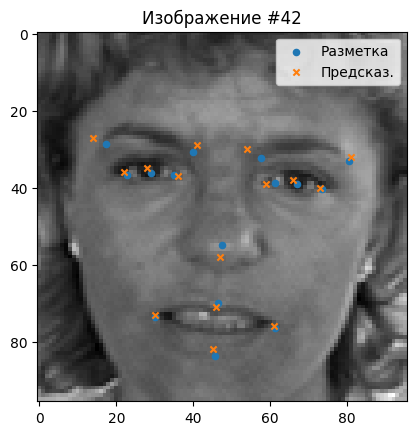

In [10]:
fig, axis = plt.subplots()
plot_sample(
    images[42], keypoints_gt[42], axis, "Изображение #42", preds=keypoints_preds[42]
)

In [11]:
keypoints_gt = keypoints_gt.reshape(-1, 15, 2)
keypoints_preds = keypoints_preds.reshape(-1, 15, 2)

В качестве ошибки я посчитаю расстояние между предсказанной и истинными точками.

Но можно использовать и __[другие](https://bobetocalo.github.io/pdf/paper_ciarp18.pdf)__:
 - Normalized mean error (NME) (normalization by factor of distance between the eye centers (pupils), or the distance between the outer eye corners (corners) and the bounding box size (height))
 - Оценки, которые бы учитывали изображения с лицами, где лица не были обнаружены вообще.
 - Детекцию точек, которые не могли быть обнаружены вовсе

In [12]:
# Calculate the Euclidean distance between ground truth and predictions
distances = np.linalg.norm(keypoints_gt - keypoints_preds, axis=2)

# Average error for each landmark
avg_error_per_point = np.mean(distances, axis=0)
# Average error
total_error_per_image = np.sum(distances, axis=1)

# Calculate the overall average error
overall_avg_error = np.mean(distances)
print(
    "Средняя ошибка предсказания точек (расстояние между истинной и предсказанной точками, MAE):",
    overall_avg_error,
)

Средняя ошибка предсказания точек (расстояние между истинной и предсказанной точками, MAE): 2.0795534853646895


Можно сравнить средние значения ошибок предсказания для каждой из ключевых точек. В нашем случае ошибка выше у точек с бровей и кончика носа.

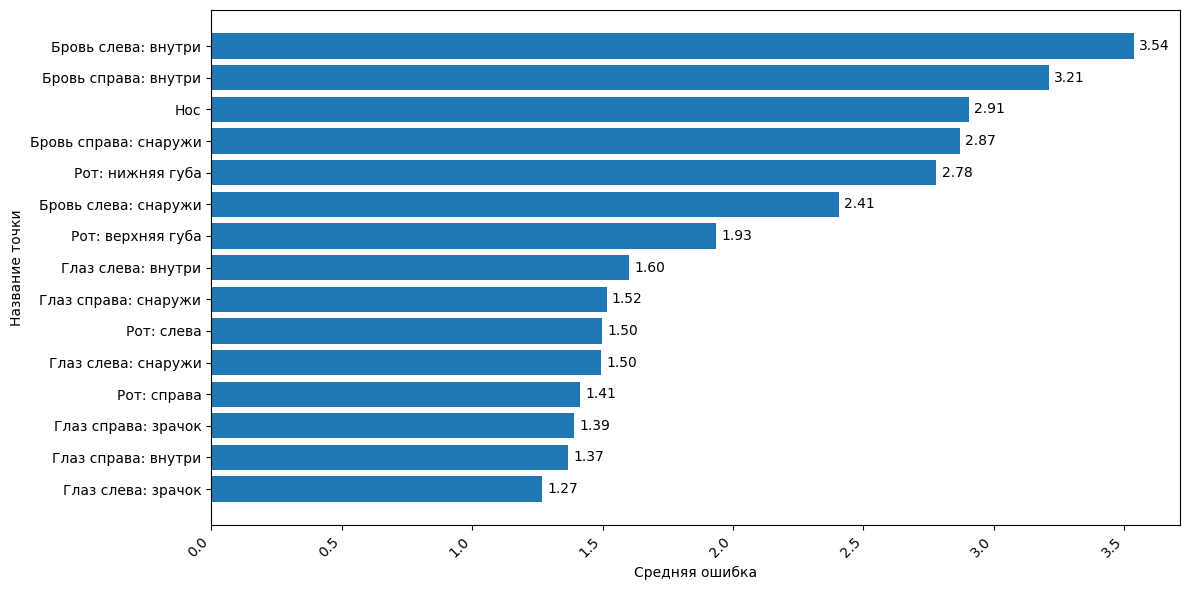

In [13]:
landmark_labels = [
    "Глаз слева: зрачок",
    "Глаз справа: зрачок",
    "Глаз слева: внутри",
    "Глаз слева: снаружи",
    "Глаз справа: внутри",
    "Глаз справа: снаружи",
    "Бровь слева: внутри",
    "Бровь слева: снаружи",
    "Бровь справа: внутри",
    "Бровь справа: снаружи",
    "Нос",
    "Рот: слева",
    "Рот: справа",
    "Рот: верхняя губа",
    "Рот: нижняя губа",
]
sorted_indices = np.argsort(avg_error_per_point)
sorted_avg_error_per_point = avg_error_per_point[sorted_indices]
sorted_landmark_labels = [landmark_labels[i] for i in sorted_indices]
plot_landmark_errors(sorted_avg_error_per_point, sorted_landmark_labels)

In [14]:
best_detections = np.argsort(total_error_per_image)[:5]
worst_detections = np.argsort(total_error_per_image)[-10:]

Хуже детектятся точки на лицах с очками (блики линз), а также с неидеально фрагментированными изображениями (см. панели ниже). Возможно, для последних можно увеличить качество детектирования, если не ограничивать bbox границами изображения, а включить детектирование лица в процесс распознавания точек (есть подозрение, что bbox с отрицательными координатами -- это важная фича, центрирующая лицо).


 5 изображений с лучшим качеством детектирования: 


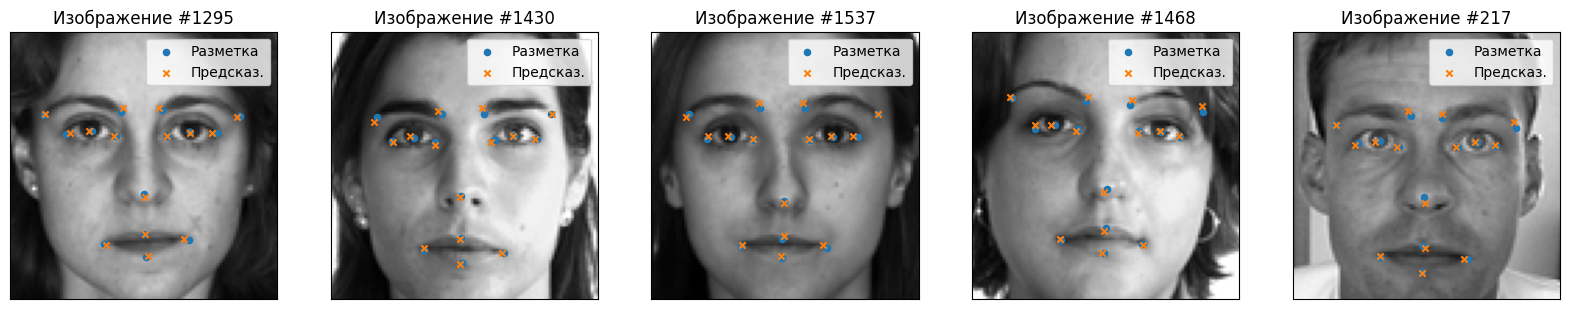


 10 изображений с худшим качеством детектирования: 


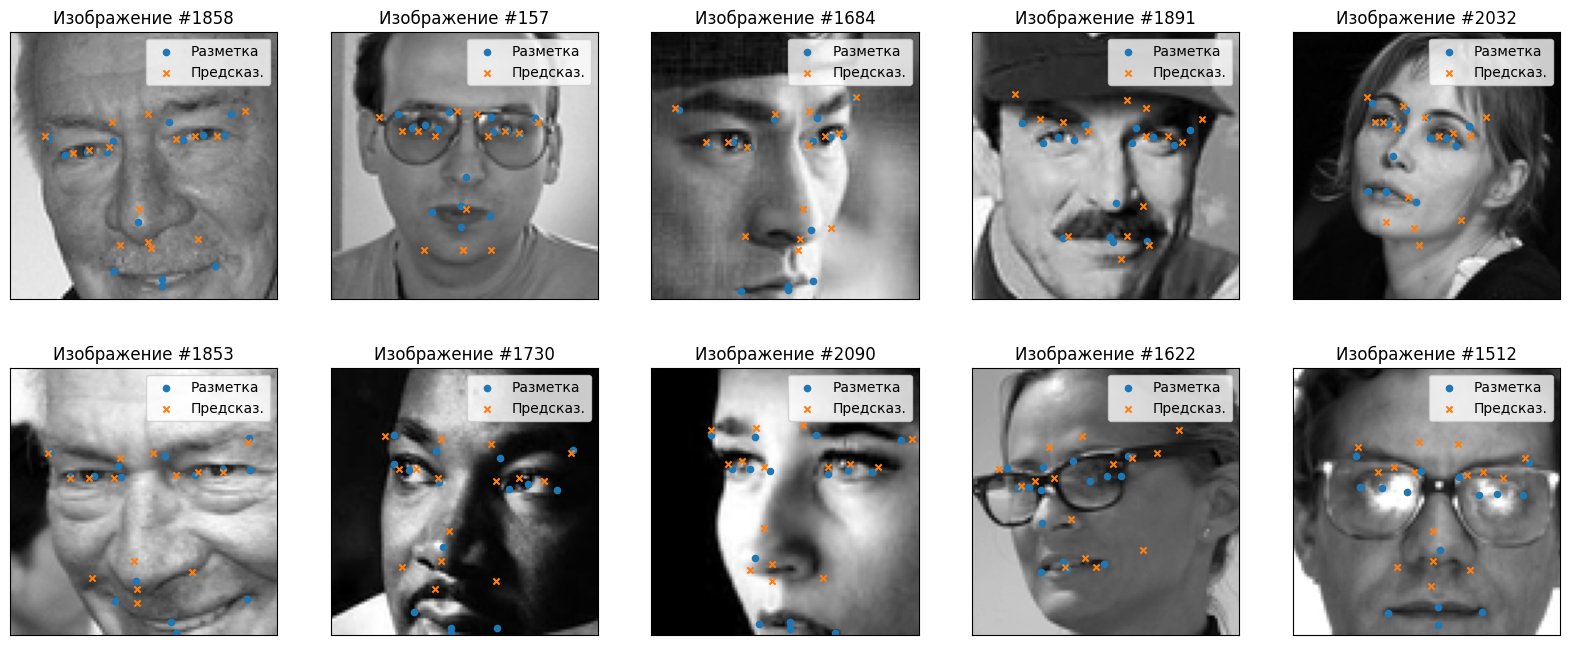

In [15]:
print("\n 5 изображений с лучшим качеством детектирования: ")
fig = plt.figure(figsize=(20, 8))
for i, image in enumerate(best_detections):
    axis = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
    plot_sample(
        images[image],
        keypoints_gt[image].flatten(),
        axis,
        f"Изображение #{image}",
        preds=keypoints_preds[image].flatten(),
    )
plt.show()

print("\n 10 изображений с худшим качеством детектирования: ")
fig = plt.figure(figsize=(20, 8))
for i, image in enumerate(worst_detections):
    axis = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
    plot_sample(
        images[image],
        keypoints_gt[image].flatten(),
        axis,
        f"Изображение #{image}",
        preds=keypoints_preds[image].flatten(),
    )
plt.show()

## Задание 3

Здесь я просто следую логике __[туториала](https://developer.supervisely.com/getting-started/python-sdk-tutorials/images/keypoints)__ для загрузки всех изображений из первого задания с разметкой от dlib в supervisely, чтобы оценить затраты времени на доразметку изображений.

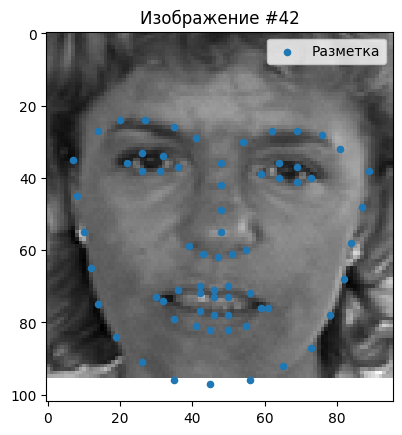

In [16]:
fig, axis = plt.subplots()

# Get predictions to use as template later
shape_42 = face_utils.shape_to_np(predictor(images[42], dlib.rectangle(0, 0, 96, 96)))
plot_sample(images[42], shape_42, axis, "Изображение #42")

In [17]:
# Initialize template
template = KeypointsTemplate()
# Add detections from images[42] to the template
for i, point in enumerate(shape_42):
    template.add_point(label=f"{i+1}", row=int(point[0]), col=int(point[1]))

In [18]:
api = sly.Api(
    server_address=os.getenv("SUPERVISELY_SERVER_ADDRESS"),
    token=os.getenv("SUPERVISELY_API_TOKEN"),
)
workspace_id = os.getenv("SUPERVISELY_WORKSPACE_ID")

In [19]:
# Initialize a new project in Supervisely
project = api.project.create(
    workspace_id, "Face Landmark Detection", change_name_if_conflict=True
)
dataset = api.dataset.create(
    project.id, "Donald Trump Images", change_name_if_conflict=True
)
print(f"Создан проект {project.id} с датасетом {dataset.id}")

Создан проект 303462 с датасетом 951965


In [20]:
print(f"Список изображений для загрузки: \n{image_files}")

Список изображений для загрузки: 
['91IM87eeuCL._CLa%7C2140%2C2000%7C910Uw3A7t4L.png%7C0%2C0%2C2140%2C2000%2B0.0%2C0.0%2C2140.0%2C2000.0_AC_UY1000_.png', 'a-donald-trump-hair-history.png', 'A13usaonutL._CLa%7C2140%2C2000%7C91lFztfK6FL.png%7C0%2C0%2C2140%2C2000%2B0.0%2C0.0%2C2140.0%2C2000.0_AC_UY1000_.png', 'A13usaonutL._CLa%7C2140%2C2000%7C91uXNyNSqFL.png%7C0%2C0%2C2140%2C2000%2B0.0%2C0.0%2C2140.0%2C2000.0_AC_UY1000_.png', 'A13usaonutL._CLa%7C2140%2C2000%7C91wBvZAff-L.png%7C0%2C0%2C2140%2C2000%2B0.0%2C0.0%2C2140.0%2C2000.0_AC_UY1000_.png', 'A13usaonutL._CLa%7C2140%2C2000%7C91ZlR7UzSJL.png%7C0%2C0%2C2140%2C2000%2B0.0%2C0.0%2C2140.0%2C2000.0_AC_UY1000_.png', 'A1cIUZSM8ML._CLa%7C2140%2C2000%7C91wyWiQemsL.png%7C0%2C0%2C2140%2C2000%2B0.0%2C0.0%2C2140.0%2C2000.0_AC_UY1000_.png', 'A1KHvCGeH6L._CLa%7C2140%2C2000%7C914cr3iqbAL.png%7C0%2C0%2C2140%2C2000%2B0.0%2C0.0%2C2140.0%2C2000.0_AC_UY1000_.png', 'A1nYNISnPeL._CLa%7C2140%2C2000%7CB1WY4g5oZiS.png%7C0%2C0%2C2140%2C2000%2B0.0%2C0.0%2C2140.0%2C20

In [21]:
# Initialize annotation class with template from image[42]
face = sly.ObjClass("face", geometry_type=sly.GraphNodes, geometry_config=template)
project_meta = sly.ProjectMeta(obj_classes=[face])
api.project.update_meta(project.id, meta=project_meta.to_json())

# Upload all images with landmarks if detected
for image_name in image_files:
    image_path = os.path.join(img_path, image_name)

    # Read image file
    image = cv2.imread(image_path)
    image_info = api.image.upload_path(dataset.id, name=image_name, path=image_path)
    img_height, img_width = image.shape[:2]
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces
    rects = detector(gray, 1)

    # Iterate over faces to get landmarks, annotate images and upload them to supervisely
    for i, rect in enumerate(rects):
        shape = predictor(gray, rect)
        landmarks = [(shape.part(j).x, shape.part(j).y) for j in range(68)]
        nodes = [
            sly.Node(label=str(i + 1), row=int(point[1]), col=int(point[0]))
            for i, point in enumerate(landmarks)
        ]
        label = sly.Label(sly.GraphNodes(nodes), face)

        # If more than 1 face in an image -- append labels to existing annotation
        if i == 0:
            ann = sly.Annotation(img_size=[img_height, img_width], labels=[label])
        else:
            ann = ann.add_labels(labels=[label])
        api.annotation.upload_ann(image_info.id, ann)

![Список загруженных файлов в датасет supervisely с превью](./screenshots/Screenshot%202024-06-12%20084916.png "Загруженные файлы")

![Список загруженных файлов в датасет supervisely с превью](./screenshots/Screenshot%202024-06-12%20085000.png "Загруженные файлы")

На разметку одного изображения с заготовленным графом требуется до двух минут. Из 20 загруженных изображений 3 (15 %) требюут доразметки (тем фактом, что на некоторых изображениях может быть более одного лица, я тут пренебрегу).

В итоге на разметку изображений с нуля ушло бы до 40 минут, а на доразметку будет достаточно до 6 минут.